# Import


In [1]:
from config import *
config_chapter3()
# This is needed to render the plots in this chapter
from plots.chapter3 import *

Finished!


In [2]:
import numpy as np

import torch 
import torch.optim as optim 
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset 

from sklearn.datasets import make_moons 
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc 

from stepbystep.v0 import StepByStep


# A Simple Classification Problem 

## Data Generation

In [3]:
X, y = make_moons(n_samples=100, noise=0.3, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=13)

In [4]:
sc = StandardScaler()
sc.fit(X_train)

X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

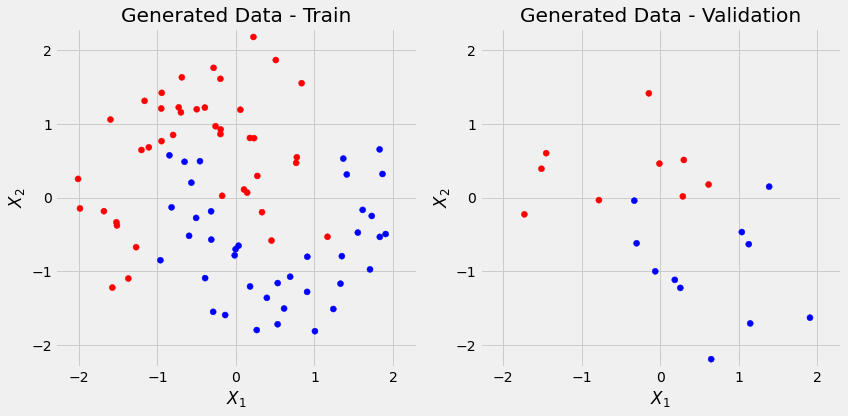

In [5]:
fig = figure1(X_train, y_train, X_val, y_val)

## Data Preparation

In [6]:
y_train[0]

1

In [7]:
torch.manual_seed(13)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()



In [8]:
y_train_tensor[0]

tensor([1.])

In [9]:
x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()


In [10]:
# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

In [11]:
# Builds a loader of each set
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True) 
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

### Model

$$
\Large 
y = b + w_1x_1 + w_2x_2 + \epsilon
$$

$$
\Large
y =
\begin{cases}
1,\ if\ \ b + w_1x_1 + w_2x_2 \ge 0
\\
0,\ if\ \ b + w_1x_1 + w_2x_2 \lt 0
\end{cases}
$$

Logits

$$
\Large
z = b + w_1x_1 + w_2x_2
$$

Probabilities

$$
\Large
\begin{cases}
& P(label=1) \approx 1.0, & if\ &z \gg 0
\\
& P(label=1) = 0.5, & if\ &z = 0
\\
& P(label=1) \approx 0.0, & if\ &z \ll 0
\end{cases}
$$

Odds Ratio

$$
\Large
odds\ ratio(p) = \frac{p}{q} = \frac{p}{1-p}
$$

In [12]:
def odds_ratio(prob):
  return prob / (1-prob)

In [13]:
p = .75
q = 1 - p
odds_ratio(p), odds_ratio(q)

(3.0, 0.3333333333333333)

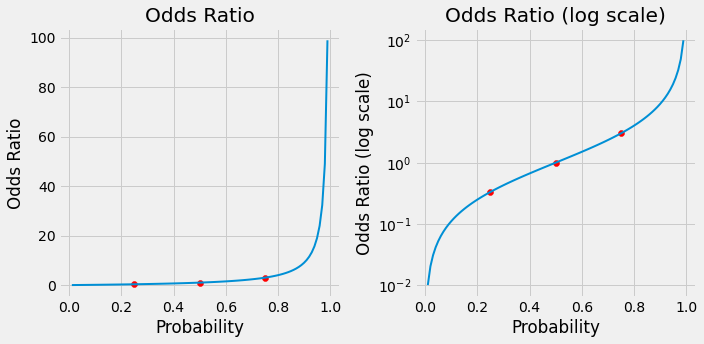

In [14]:
fig = figure2(p)

### Log Odds Ratio

$$
\Large 
log\ odds\ ratio(p) = log\left(\frac{p}{1-p}\right)
$$

In [15]:
def log_odds_ratio(prob):
  return np.log(odds_ratio(prob))

p = .75
q = 1 - p
log_odds_ratio(p), log_odds_ratio(q)

(1.0986122886681098, -1.0986122886681098)

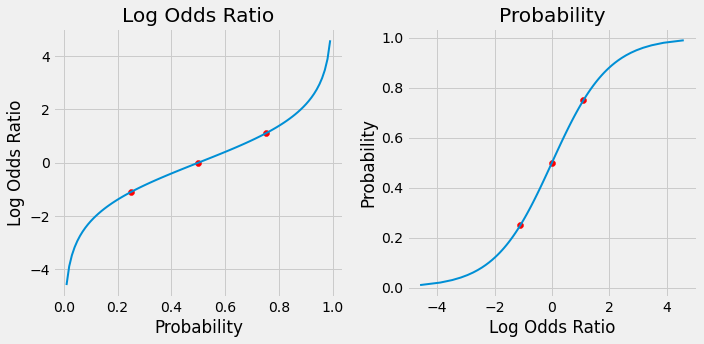

In [17]:
fig = figure3(p)

### From Logits to Probabilities

$$
\Large
\begin{array}{rrl}
b + w_1x_1 + w_2x_2 = &z& = &log\left(\frac{p}{1-p}\right)
\\
e^{b + w_1x_1 + w_2x_2} = &e^z& = &\frac{p}{1-p}
\end{array}
$$

$$
\Large
\begin{array}{rl}
\frac{1}{e^z}& = &\frac{1-p}{p}
\\
e^{-z}& = &\frac{1}{p} - 1
\\
1 + e^{-z}& = &\frac{1}{p}
\\
p& = &\frac{1}{1 + e^{-z}}
\end{array}
$$

In [18]:
def sigmoid(z):
  return 1 / (1 + np.exp((-z)))

p = .75
q = 1 - p
sigmoid(log_odds_ratio(p)), sigmoid(log_odds_ratio(q))

(0.75, 0.25)

### Sigmoid

In [19]:
torch.sigmoid(torch.tensor(1.0986)), torch.sigmoid(torch.tensor(-1.0986))

(tensor(0.7500), tensor(0.2500))

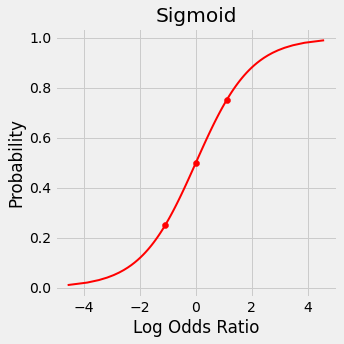

In [21]:
fig = figure4(p)

### Logistic Regression

$$
\Large P(y=1) = \sigma(z) = \sigma(b+w_1x_1+w_2x_2)
$$

In [22]:
torch.manual_seed(42)
model1 = nn.Sequential()
model1.add_module('linear', nn.Linear(2, 1))
model1.add_module('sigmoid', nn.Sigmoid())
print(model1.state_dict())

OrderedDict([('linear.weight', tensor([[0.5406, 0.5869]])), ('linear.bias', tensor([-0.1657]))])


### Note on Notation

$$
\large W =
\underset{(3 \times 1)}{
\begin{bmatrix}
b \\
w_1 \\
w_2
\end{bmatrix}};
X = 
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}
$$

$$
\large 
\begin{aligned}
z
& = W^T \cdot X
=
\underset{(1 \times 3)}{
\begin{bmatrix}
- & w^{T} & -\\
\end{bmatrix}}
\cdot
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}
= \underset{(1 \times 3)}{
\begin{bmatrix}
b & w_1 & w_2
\end{bmatrix}}
\cdot
\underset{(3 \times 1)}{
\begin{bmatrix}
1 \\
x_1 \\
x_2
\end{bmatrix}}\\
& = b + w_1x_1 + w_2x_2
\end{aligned}
$$

## Loss

$$
\Large y_i = 1 \Rightarrow error_i=log(P(y_i=1))
$$

$$
\Large P(y_i=0)=1-P(y_i=1)
$$

$$
\Large y_i = 0 \Rightarrow error_i=log(1-P(y_i=1))
$$

$$
\Large BCE(y)={-\frac{1}{(N_{pos}+N_{neg})}\Bigg[{\sum_{i=1}^{N_{pos}}{log(P(y_i=1))} + \sum_{i=1}^{N_{neg}}{log(1 - P(y_i=1))}}\Bigg]}
$$

In [23]:
dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([.9, .2])

# Postive Class (labels == 1)
positive_pred = dummy_predictions[dummy_labels == 1]


print(positive_pred)

tensor([0.9000])


In [25]:
first_summation = torch.log(positive_pred)
print(first_summation)

tensor([-0.1054])


In [27]:
first_summation = torch.log(positive_pred).sum()
print(first_summation)

tensor(-0.1054)


In [28]:
# Negative Class (labels == 0)
negative_pred = dummy_predictions[dummy_labels == 0]
print(negative_pred)


tensor([0.2000])


In [29]:
second_summation = torch.log(1 - negative_pred)
print(second_summation)

tensor([-0.2231])


In [30]:
second_summation = torch.log(1 - negative_pred).sum()
print(second_summation)

tensor(-0.2231)


In [31]:
# n_total = n_pos + n_neg
n_total = dummy_labels.size(0)
print(n_total)

2


In [32]:
loss = -(first_summation + second_summation) / n_total 
loss

tensor(0.1643)

$$
\Large BCE(y)={-\frac{1}{N}\sum_{i=1}^{N}{\left[y_i \cdot log(P(y_i=1)) + (1-y_i) \cdot log(1-P(y_i=1))\right]}}
$$

In [33]:
summation = torch.sum(
    dummy_labels * torch.log(dummy_predictions) +
    (1 - dummy_labels) * torch.log(1 - dummy_predictions)

)

loss = -summation / n_total
loss

tensor(0.1643)

### BCELoss

In [34]:
loss_fn = nn.BCELoss(reduction='mean')


loss_fn

BCELoss()

In [35]:
dummy_labels = torch.tensor([1.0, 0.0])
dummy_predictions = torch.tensor([.9, .2])

# RIGHT
right_loss = loss_fn(dummy_predictions, dummy_labels)

# WRONG 
wrong_loss = loss_fn(dummy_labels, dummy_predictions)

print(right_loss, wrong_loss)

tensor(0.1643) tensor(15.0000)


### BCEWithLogitsLoss



In [36]:
loss_fn_logits = nn.BCEWithLogitsLoss(reduction='mean')

loss_fn_logits

BCEWithLogitsLoss()

In [38]:
logit1 = log_odds_ratio(.9)
logit2 = log_odds_ratio(.2)

dummy_labels = torch.tensor([1.0, 0.0])
dummy_logits = torch.tensor([logit1, logit2])

print(dummy_logits)

tensor([ 2.1972, -1.3863], dtype=torch.float64)


In [39]:
loss = loss_fn_logits(dummy_logits, dummy_labels)
loss

tensor(0.1643)

### Imbalanced Dataset

In [40]:
dummy_imb_labels = torch.tensor([1.0, 0.0, 0.0, 0.0])
dummy_imb_logits = torch.tensor([logit1, logit2, logit2, logit2])

$$
\Large pos\_weight = \frac{\# points\ in\ negative\ class}{\# points\ in\ positive\ class}
$$

In [41]:
n_neg = (dummy_imb_labels == 0).sum().float()
print(n_neg)

tensor(3.)


In [42]:
n_pos = (dummy_imb_labels == 1).sum().float()
print(n_pos)

tensor(1.)


In [43]:
pos_weight = (n_neg/n_pos)
print(pos_weight)

tensor(3.)


In [44]:
pos_weight = (n_neg/n_pos).view(1,)
print(pos_weight)

tensor([3.])


In [45]:
loss_fn_imb = nn.BCEWithLogitsLoss(reduction='mean', pos_weight=pos_weight)

loss_fn_imb

BCEWithLogitsLoss()

In [46]:
loss = loss_fn_imb(dummy_imb_logits, dummy_imb_labels)
loss

tensor(0.2464)

$$
\Large weighted\ average = \frac{pos\_weight \cdot \sum_{i=1}^{N_{pos}}{loss_i}+\sum_{i=1}^{N_{neg}}{loss_i}}{pos\_weight \cdot N_{pos}+N_{neg}}
$$

$$
\Large BCEWithLogitsLoss = \frac{pos\_weight \cdot \sum_{i=1}^{N_{pos}}{loss_i}+\sum_{i=1}^{N_{neg}}{loss_i}}{N_{pos}+N_{neg}}
$$

In [48]:
loss_fn_imb_sum = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=pos_weight)

loss = loss_fn_imb_sum(dummy_imb_logits, dummy_imb_labels)

loss = loss / (pos_weight * n_pos + n_neg)
loss

tensor([0.1643])

## Model Configuration

In [49]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(2, 1))

# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE loss function 
loss_fn = nn.BCEWithLogitsLoss()

## Model Training

In [50]:
n_epochs = 100

sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.train(n_epochs)

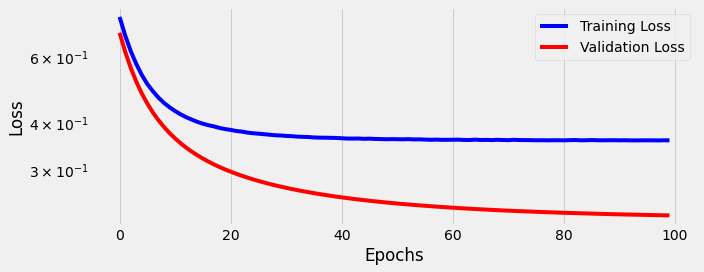

In [51]:
fig = sbs.plot_losses()

In [52]:
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[ 1.1806, -1.8693]])), ('linear.bias', tensor([-0.0591]))])


$$
\large
\begin{array}{ccccccc}
z & = & b & + & w_1x_1 & + & w_2x_2
\\
z & = & -0.0591 & + & 1.1806x_1 & - & 1.8693x_2
\end{array}
$$

### Making Predictions (Logits)

In [53]:
predictions = sbs.predict(x_train_tensor[:4])
predictions

array([[ 0.20345592],
       [ 2.9444451 ],
       [ 3.6933177 ],
       [-1.2334073 ]], dtype=float32)

### Making Predictions (Probabilities)

In [54]:
probabilities = sigmoid(predictions)
probabilities

array([[0.5506892 ],
       [0.9500003 ],
       [0.9757152 ],
       [0.22558564]], dtype=float32)